In [1]:
import numpy as np
import re, json, csv
import torch
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable
from bson.objectid import ObjectId
from torchmetrics.text.bert import BERTScore
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bleu import BLEUScore
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoConfig, AutoTokenizer
from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.functional.text.bert import _get_precision_recall_f1
from functools import partial
from collections import Counter, defaultdict
from itertools import chain
from math import log
from multiprocessing import Pool
from typing import List
from pymongo import MongoClient
from typing import Set

pprint = PrettyPrinter().pprint

In [2]:
DEVICE = "cpu"

In [3]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]

### Get model

### Calculate ROUGE

In [4]:
def compute_rouge_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    tokenizer_fn = lambda x: tokenizer.convert_ids_to_tokens(tokenizer.encode(x))
    rouge_metric = ROUGEScore(tokenizer=tokenizer_fn)
    # rouge_metric.update(pred_senteces, target_sentences)
    return rouge_metric(pred_senteces, target_sentences)

### Calculate BLEU

In [5]:
def compute_bleu_score(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer):
    bleu_metric = BLEUScore(tokenizer=tokenizer)
    bleu_metric.update(pred_senteces, [[s] for s in target_sentences])
    return bleu_metric.compute()

### Calculate BERT score

In [6]:
def update(self, preds: List[str], targets: List[str]) -> None:
        """Store predictions/references for computing BERT scores.

        It is necessary to store sentences in a tokenized form to ensure the DDP mode working.
        """
        
        preds_tokenized_data = self.tokenizer(preds, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        preds_dict = {"input_ids": preds_tokenized_data["input_ids"], "attention_mask": preds_tokenized_data["attention_mask"]}
        target_tokenized_data = self.tokenizer(targets, max_length=1024, truncation=True, return_tensors="pt", padding=True)
        target_dict = {"input_ids": target_tokenized_data["input_ids"], "attention_mask": target_tokenized_data["attention_mask"]}

        self.preds_input_ids.append(preds_dict["input_ids"])
        self.preds_attention_mask.append(preds_dict["attention_mask"])
        self.target_input_ids.append(target_dict["input_ids"])
        self.target_attention_mask.append(target_dict["attention_mask"])
        
def compute_bert_score2(target_sentences : Iterable[str], pred_senteces : Iterable[str], tokenizer, model : torch.nn.Module, *args, **kwargs):
    BERTScore.update = update
    user_forward_fn = lambda model, d: model.get_input_embeddings()(d["input_ids"])
    bert_metric = BERTScore(model=model, user_tokenizer=tokenizer, user_forward_fn=user_forward_fn, device=DEVICE, verbose=True, num_layers=0, max_length=600)
    # bert_metric.update = update
    output = {}
    for key, vals in bert_metric(preds=pred_senteces, targets=target_sentences).items():
        output[key] = float(np.mean(vals))
    
    return output
#     bert_metric.update(bert_metric, pred_senteces, target_sentences)
#     return bert_metric.compute()

In [7]:
def get_kernel_prefixes(kernel : str) -> Set[str]:
    prefixes = set()
    one_line_kernel = kernel.replace("\n", " ")
    cuda_header_prefix_re = re.compile("__(host|global|device)__")
    
    prefixes.update(cuda_header_prefix_re.findall(one_line_kernel))
    return prefixes
        

In [8]:
def compute_metrics(sources : List[str], targets : List[str], preds : List[str], tokenizer, model : torch.nn.Module, used_ratio : float = 1.0):
    assert used_ratio > 0 and used_ratio <= 1
    assert len(targets) == len(preds)
    
    samples = list(zip(targets, preds))
    np.random.shuffle(samples)
    n = round(len(samples) * used_ratio)
    
    print(f"Using random {n} samples")
        
    metrics_d = {
        "device" : {},
        "host" : {},
        "global" : {}
    }
    
    device_sentences = []
    host_sentences = []
    global_sentences = []
    
    pb = tqdm(zip(sources, targets, preds))
    i = 0
    for src, target, pred in pb:
        found = False
        
        if found := (src.find("__device__") != -1):
            device_sentences.append((target, pred))
        if found := (src.find("__host__") != -1):
            host_sentences.append((target, pred))
        if found := (src.find("__global__") != -1):
            global_sentences.append((target, pred))
        
        if not found:
            continue
        
        i += 1
        pb.set_description_str(f"{i}")
        if i >= n:
            break
    
    if len(device_sentences) == 0:
        print("WARNING: no device sample")
        # metrics_d["__device__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        device_targets, device_preds = zip(*device_sentences)
        metrics_d["device"] = {
            "rouge" : compute_rouge_score(device_targets, device_preds, tokenizer),
            "bleu" : compute_bleu_score(device_targets, device_preds, tokenizer),
            "bert" : compute_bert_score2(device_targets, device_preds, tokenizer, model)
        }
        print(f"__device__ ({len(device_sentences)})")
        pprint(metrics_d["device"])
        
    if len(host_sentences) == 0:
        print("WARNING: no host samples")
        # metrics_d["__host__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        host_targets, host_preds = zip(*host_sentences)
        metrics_d["host"] = {
            "rouge" : compute_rouge_score(host_targets, host_preds, tokenizer),
            "bleu" : compute_bleu_score(host_targets, host_preds, tokenizer),
            "bert" : compute_bert_score2(host_targets, host_preds, tokenizer, model)
        }
        print(f"__host__ ({len(host_sentences)})")
        pprint(metrics_d["host"])
        
    if len(global_sentences) == 0:
        print("WARNING: no global samples")
        # metrics_d["__global__"] = {"rouge" : 0, "bleu" : 0, "bert" : 0}
    else:
        global_targets, global_preds = zip(*global_sentences)
        metrics_d["global"] = {
            "rouge" : compute_rouge_score(global_targets, global_preds, tokenizer),
            "bleu" : compute_bleu_score(global_targets, global_preds, tokenizer),
            "bert" : compute_bert_score2(global_targets, global_preds, tokenizer, model)
        }
        print(f"__global__ ({len(global_sentences)})")
        pprint(metrics_d["global"])
        
    # Weights 
    total = len(device_sentences) + len(host_sentences) + len(global_sentences)
    d_w = len(device_sentences) / total
    h_w = len(host_sentences) / total
    g_w = len(global_sentences) / total
    
    def calculate_total_metric(ds : List[dict], ws : List[float]):        
        def calculate(ds : List[dict], ws : List[float], key : str):
            r = 0
            for d, w in zip(ds, ws):
                if d is None:
                    continue
                
                r += d.get(key, 0) * w
            return r
        
        total_rouge = {}
        
        for d in ds:
            if d is None:
                continue
            for key in d.keys():
                if key in total_rouge:
                    continue
                
                total_rouge[key] = calculate(ds, ws, key)
        return total_rouge
    
    metrics_d["total"] = {"rouge" : {}, "bleu" : -1, "bert" : {}}
    metrics_d["total"]["rouge"] = calculate_total_metric(
        [metrics_d["device"].get("rouge"), metrics_d["host"].get("rouge"), metrics_d["global"].get("rouge")],
        [d_w, h_w, g_w]
    )
    
    metrics_d["total"]["bleu"] = metrics_d["device"].get("bleu",0)*d_w + metrics_d["host"].get("bleu",0)*h_w + metrics_d["global"].get("bleu",0)*g_w

    
    metrics_d["total"]["bert"] = calculate_total_metric(
        [metrics_d["device"].get("bert"), metrics_d["host"].get("bert"), metrics_d["global"].get("bert")],
        [d_w, h_w, g_w]
    )
    
    print("total")
    pprint(metrics_d["total"])
    
    # rouge = compute_rouge_score(targets, preds, tokenizer)
    # pprint({"rouge" : rouge})

    # bleu = compute_bleu_score(targets, preds, tokenizer)
    # pprint({"bleu" : bleu})

    # bert = compute_bert_score2(targets, preds, tokenizer, model)
    # pprint({"bert" : bert})
    
    return metrics_d

# BART

In [9]:

def get_bart_model(model_name : str, model_path : str, tokenizer):

    configuration = AutoConfig.from_pretrained(model_name)

    model = AutoModelForSeq2SeqLM.from_config(configuration).to(DEVICE)
    model.resize_token_embeddings(len(tokenizer))
    model_dict = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(model_dict["model_dict"])
    
    return model, model_dict

In [13]:

model_path = "/home/xsaman02/Project/models/bart/bart.evaluated.pt"
tokenizer_name = "facebook/bart-large"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=False, model_max_length=800, add_bos_token=True)
model, model_d = get_bart_model(tokenizer_name, model_path, tokenizer)


In [19]:
used_ratio = 0.01
metrics = compute_metrics(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("pred_sentences"), tokenizer, model, used_ratio)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.releas

Using random 389 samples


0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f038f7fbdc0>
Traceback (most recent call last):
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/home/xsaman02/miniconda3/envs/diplomka/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


  0%|          | 0/9 [00:20<?, ?it/s]

__device__ (520)
{'bert': {'f1': 0.587616716325283,
          'precision': 0.5443727339689548,
          'recall': 0.6573521455320028},
 'bleu': tensor(0.0190),
 'rouge': {'rouge1_fmeasure': tensor(0.2733),
           'rouge1_precision': tensor(0.1807),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1231),
           'rouge2_precision': tensor(0.0855),
           'rouge2_recall': tensor(0.5154),
           'rougeL_fmeasure': tensor(0.2733),
           'rougeL_precision': tensor(0.1807),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.2706),
           'rougeLsum_precision': tensor(0.1788),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

__host__ (264)
{'bert': {'f1': 0.5618912665681406,
          'precision': 0.5053239637477831,
          'recall': 0.662569123461391},
 'bleu': tensor(0.0113),
 'rouge': {'rouge1_fmeasure': tensor(0.3063),
           'rouge1_precision': tensor(0.2009),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.1300),
           'rouge2_precision': tensor(0.0861),
           'rouge2_recall': tensor(0.5095),
           'rougeL_fmeasure': tensor(0.3063),
           'rougeL_precision': tensor(0.2009),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.3026),
           'rougeLsum_precision': tensor(0.1981),
           'rougeLsum_recall': tensor(1.)}}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

__global__ (389)
{'bert': {'f1': 0.7075400108083661,
          'precision': 0.7115276986804904,
          'recall': 0.7132776129061887},
 'bleu': tensor(0.0067),
 'rouge': {'rouge1_fmeasure': tensor(0.1463),
           'rouge1_precision': tensor(0.0829),
           'rouge1_recall': tensor(1.),
           'rouge2_fmeasure': tensor(0.0527),
           'rouge2_precision': tensor(0.0291),
           'rouge2_recall': tensor(0.4987),
           'rougeL_fmeasure': tensor(0.1463),
           'rougeL_precision': tensor(0.0829),
           'rougeL_recall': tensor(1.),
           'rougeLsum_fmeasure': tensor(0.1456),
           'rougeLsum_precision': tensor(0.0825),
           'rougeLsum_recall': tensor(1.)}}
total
{'bert': {'f1': 0.6215968039791907,
          'precision': 0.5910175813128576,
          'recall': 0.6770727669999625},
 'bleu': tensor(0.0132),
 'rouge': {'rouge1_fmeasure': tensor(0.2386),
           'rouge1_precision': tensor(0.1528),
           'rouge1_recall': tensor(1.),
        

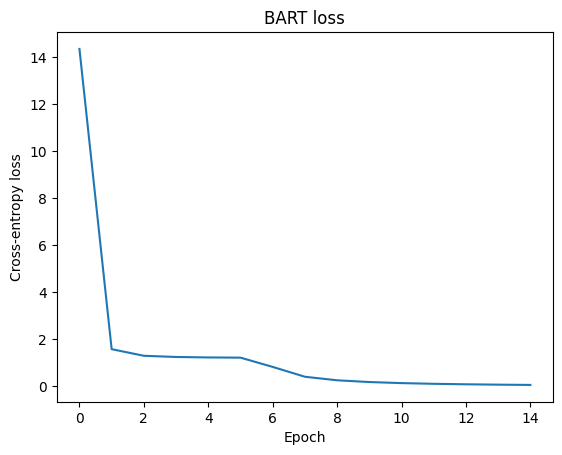

Epochs: 15
Max: 14.342219352722168, epoch: 0
Min: 0.0417606420814991, epoch: 14


In [15]:
loss_list = model_d.get("loss_list")
plt.figure()
plt.title("BART loss")
plt.ylabel("Cross-entropy loss")
plt.xlabel("Epoch")
plt.plot(loss_list)
plt.show()

print(f"Epochs: {len(loss_list)}")
print(f"Max: {max(loss_list)}, epoch: {np.argmax(loss_list)}")
print(f"Min: {min(loss_list)}, epoch: {np.argmin(loss_list)}")

### Average lengths

In [7]:
tgr_ls = 0
tgr_cs = 0
prd_ls = 0
prd_cs = 0
s = len(model_d.get("source_sentences"))
for tgr, prd in tqdm(zip(model_d.get("source_sentences"), model_d.get("target_sentences"))):
    # tgr = tgr.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    # prd = prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat")
    
    tgr_ls += tgr.count("\n")
    prd_ls += prd.count("\n")
    
    tgr_cs += len(tgr)
    prd_cs += len(prd)
    
print("Average target lines per sample: {:.3f}".format(tgr_ls/s))
print("Average predic lines per sample: {:.3f}".format(prd_ls/s))
print("Average target sample size: {:.3f}".format(tgr_cs/s))
print("Average predic sample size: {:.3f}".format(prd_cs/s))


0it [00:00, ?it/s]

Average target lines per sample: 5.284
Average predic lines per sample: 27.398
Average target sample size: 272.834
Average predic sample size: 970.676


### Examples

In [26]:
# Generate random example from evaluation
samples = list(zip(model_d.get("source_sentences"), model_d.get("target_sentences"), model_d.get("predic_sentences")))
np.random.shuffle(samples)
for src, tgr, prd in zip(*zip(*samples)):
    
    print("SOURCE:")
    print(src)
    print("\nTARGET:")
    print(tgr)
    print("\nPREDICT:")
    # print(prd.replace(";", ";\n").replace("{", "{\n").replace("}", "}\n").replace("int", "\nint").replace("float", "\nfloat"))
    print(prd)
    print("#--------------------------#")
    break

SOURCE:
// subtract

inline __host__ __device__ int2 operator-(int2 a, int2 b)

TARGET:
// subtract

inline __host__ __device__ int2 operator-(int2 a, int2 b)
{
    return make_int2(a.x - b.x, a.y - b.y);
}

PREDICT:
______/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////